In [1]:
# from TL import preproc_TL 
%matplotlib inline 
import matplotlib.pyplot as plt
from prep_data import Dataset 
from torch.utils.data import DataLoader
from LSTM_Net import LSTM_Net
import torch.nn as nn 
import torch 
import numpy as np
import math 
import gc
import time 
from skimage.transform import resize
import sys
sys.path.append("../")
from util import * 
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# fed the seed for reproducibility 

In [2]:
torch.backends.cudnn.deterministic = True
# random.seed(1)
# np.random.seed(1)
# torch.manual_seed(1)
# torch.cuda.manual_seed(1)



## Global variable 

In [3]:
# data paths and parameters
data_path = '../LSTM_Otway_submitted_v2/data'

# SNR=0.7
SNR=1.1
# SNR=0.9


# base_path = f"{data_path}/noisy_70SNR_base_otw.npy" 
# mon_path = f"{data_path}/noisy_70SNR_mon_otw.npy" 


# --- Clean no noise
# Mclean_path = f"{data_path}/mon_otw_c.npy" 

base_path = f"{data_path}/noisy_{SNR}SNR_base_otw.npy" 
mon_path = f"{data_path}/noisy_{SNR}SNR_mon_otw.npy" 
Mclean_path = f"{data_path}/noisy_{SNR}SNR_mon_otw_c.npy" 



parm = {
 'nt': 1250,
 'ng': 605,
 'ns': 121,
 'dt': 0.002,
 'dg': 0.004000000189989805,
 'ds': 1.0,
 'ot': 0.0,
 'og': 0.012000000104308128,
 'os': 0.0}


# Hyperparameters for training
# ----------------This is for the first 70 and 21 feature length 
# batchsz = 64 
# # Hyperparameters for training
# num_epochs = 100 
# LR = 0.002
# hsz = 100
# act = 'tanh'
# n_layer=1
# bias= False
# dropout = 0.


batchsz = 64 
num_epochs = 100 
LR = 0.002
hsz = 150
act = 'tanh'
n_layer=2
bias= False
dropout = 0.


# define the window for plotting  
# start = 100
# last =  900 

# # define the overburden window 
start = 450
last =  650 

epoch=99

feature_length=41
# feature_length=21

hyperpar = f"_lr{LR}_nlayer{n_layer}_act{act}_bias{bias}_batchsz{batchsz}-{feature_length}-{SNR}_time_start{start}_end{last}"

# This is for the initially 70 and feature length 21
# hyperpar = f"_lr{LR}_nlayer{n_layer}_act{act}_bias{bias}_batchsz{batchsz}_time_start{start}_end{last}"
net_path = "./Network/"

net = f'{net_path}LSTM_Otway_epc{epoch}{hyperpar}.pth'


last =  900 

batchsz=1

# -----------------------------------------------#
# RSF PATH 
# path = '/home/alaliaa/Time_lapse_ML/ML_Models2/data/'
# base = path + 'Base_data.rsf'
# mon = path + 'MonNoisy_data.rsf'

In [4]:
# # ###Adding noise 

# Mclean = np.load(Mclean_path)
# print(Mclean.shape)
# energy_Mclean = (Mclean**2).mean()
# SNR = 0.7
# noise = np.random.normal(0., np.sqrt(energy_Mclean/SNR ), Mclean.shape) 
# energy_noise = (noise**2).mean()


# print(energy_noise),print(energy_Mclean)
# print(f"SNR = {energy_Mclean/energy_noise}")

# Mclean_n = Mclean + noise 


# # Save the noisy data 
# Mclean_n_path = f"{data_path}/noisy_{SNR}SNR_mon_otw_c.npy" 

# np.save(Mclean_n_path,Mclean_n)



In [5]:
# vmin, vmax = np.percentile(Mclean_n[60,], [2,98])
# plt.imshow(Mclean_n[60,].T,cmap='seismic',vmin=vmin,vmax=vmax)
net

'./Network/LSTM_Otway_epc99_lr0.002_nlayer2_acttanh_biasFalse_batchsz64-41-1.1_time_start450_end650.pth'

In [6]:

base = np.load(base_path)
mon = np.load(mon_path)
Mclean = np.load(Mclean_path)


ns,ng,nt = base.shape
print ('ns',ns,'ng',ng,'nt',nt)



# Take only few shots 
base = base[50:70:2,]
mon = mon[50:70:2,]
Mclean = Mclean[50:70:2,]
ns,ng,nt_ = base.shape



base = base.reshape((ns*ng,nt))
mon = mon.reshape((ns*ng,nt))
Mclean = Mclean.reshape((ns*ng,nt))

print('data shapeed to 2d',base.shape)






ns 120 ng 609 nt 1250
data shapeed to 2d (6090, 1250)


In [7]:
''' Pre Processing the data for trainign 
    - specify the infer time window 
    - scale the data 
    - Rolling window ??! 

'''


def scale_data(data=None):
    print('shape of data that will be scaled', data.shape)
    assert len(data.shape)==2
    ng,nt = data.shape  
    
    data = data.T
    scaler= MinMaxScaler(feature_range=(-1,1))
    # scaler= StandardScaler()
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    scaled_data = scaled_data.T 


    return scaled_data,scaler
    return scaled_data,scaler
         

# The training part from the trace 
base = base[:,start:last]
mon = mon[:,start:last] 
Mclean = Mclean[:,start:last] 


# Scaling 
base, base_scaler = scale_data(base) 
mon , mon_scaler  = scale_data(mon) 


# move to torch 
base = torch.from_numpy(base).double()
mon  = torch.from_numpy(mon).double()





shape of data that will be scaled (6090, 450)
shape of data that will be scaled (6090, 450)


In [8]:
def window (x,dimension=-1,size=11,step=1):
    ''' x has to be pytorch tensor'''
    return x.unfold(dimension,size,step)


print(base.shape)
base_win =window(base,size=feature_length,step=1)
mon_win =window(mon,size=feature_length,step=1)[:,:,feature_length//2]
mon_win = mon_win.view(mon_win.shape[0],mon_win.shape[1],-1)


print(base_win.shape),print(mon_win.shape)


torch.Size([6090, 450])
torch.Size([6090, 410, 41])
torch.Size([6090, 410, 1])


(None, None)

In [9]:
# Load the mdoel 

model = LSTM_Net(input_size=base_win.shape[-1], hidden_layer_size=hsz, output_size=mon_win.shape[-1],
                batch_sz=batchsz,num_lstm_layer=n_layer,activation=act,dropout=0,bias=bias)
# model = LSTM_Net2(1,hsz,1,batchsz)
model.load_state_dict(torch.load(net))
model.cuda().double()
model.eval()



LSTM_Net(
  (lstm): LSTM(41, 150, num_layers=2, bias=False, batch_first=True)
  (linear): Linear(in_features=150, out_features=1, bias=False)
  (linear2): Linear(in_features=1, out_features=1, bias=False)
)

In [10]:
''' Main inference ''' 

Pred = torch.zeros_like(mon_win)
count = 0 
with torch.no_grad():
    for i in range (base_win.shape[0]//batchsz): 
        model.h_init()
        inp = base_win[count:count+batchsz,].cuda()
        Pred_batch = model(inp)
        Pred[count:count+batchsz,] = Pred_batch.detach().cpu()
        count += batchsz
# Pred = Pred.numpy()[:,:,0]
# mon = mon.detach().numpy()[:,:,0]
# base = base.detach().numpy()[:,:,0]


Pred = mon_scaler.inverse_transform(Pred[:,:,-1].T).T    

base = base_scaler.inverse_transform(base.T).T    
mon = mon_scaler.inverse_transform(mon.T).T    


In [11]:
mon.shape

(6090, 450)

In [12]:
B=base.reshape((ns,ng,last-start))[:,:,feature_length//2:-(feature_length//2)]
M=mon.reshape((ns,ng,last-start))[:,:,feature_length//2:-(feature_length//2)]
Mc = Mclean.reshape((ns,ng,last-start))[:,:,feature_length//2:-(feature_length//2)]
Pr = Pred.reshape((ns,ng,last-start-feature_length+1))


# base= B 
# mon = M
# Mclean = Mc
# Pred = Pr
 
# base = base[1*ng:2*ng,:]
# mon = mon[1*ng:2*ng,:]
# Mclean = Mclean[1*ng:2*ng,:]
# Pred = Pred[1*ng:2*ng,:]

In [13]:
# Metrics 

def RMS(a):
    N = a.shape[0]
    return np.sqrt(1/N * np.sum(a**2))
#     return np.sqrt(np.mean(a**2))

def NRMS (B,M,ti,tf):
    N = B.shape[0]
    b = B[:,ti:tf].copy()
    m = M[:,ti:tf].copy()
    num = RMS(b-m)
    den = RMS(b)+RMS(m)
    score = 200 * num/den
    return score
    
def phi(b,m):
    num = np.sum(b*m)
    den = np.sqrt(np.sum(b**2)*np.sum(m**2))
    return num/den
    
def predictability(B,M,ti,tf):
    N = B.shape[0]
    b = B[:,ti:tf].copy()
    m = M[:,ti:tf].copy()
    w = b.shape[-1]
    tao = 0
    num = 0 
    den = 0
    for tao in range(w//2): 
        phi_bm = phi(b[tao:tao+w//2],m[tao:tao+w//2])
        phi_bb = phi(b[tao:tao+w//2],b[tao:tao+w//2])
        phi_mm = phi(m[tao:tao+w//2],m[tao:tao+w//2])
        num   += phi_bm * phi_bm
        den   += phi_bb * phi_mm
    score = 100 * num/den
    return score


metric window is [0.9-1.31]
metric window is [0.9-1.31]
metric window is [0.9-1.31]
metric window is [0.9-1.31]


/tmp/ipykernel_33101/2698285185.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return num/den


metric window is [0.9-1.31]


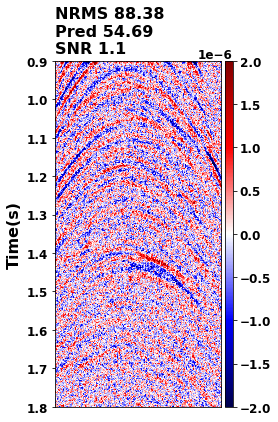

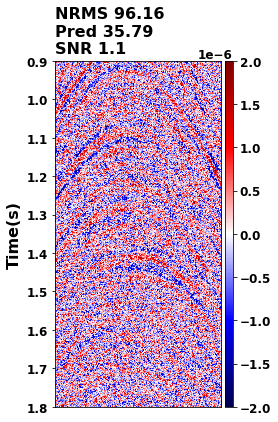

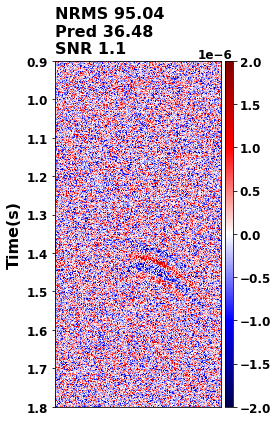

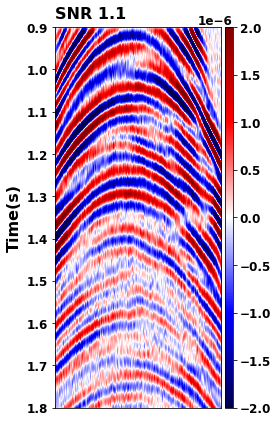

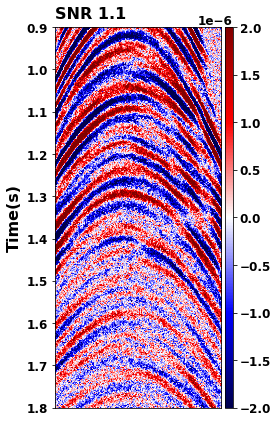

In [14]:
''' Shot differeces plots ''' 
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Shot plotting 

# matplotlib.rc('image', cmap='gray')    
matplotlib.rc('image', cmap='seismic') 
font = {
'weight' : 'bold',
'size'   : 12}
matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 12})
dt = 0.002
vmax = 2e-6
vmin = -vmax
# vmax = .15
# vmin = -.15
# vmin, vmax = np.percentile((Mclean-base).T,[2,98])




ncols=5
#-----------------------------------------------------------

# def plot_differences(shot1,shot2,ncols,savedir,metric=True):

#     # Measure metric window
#     ti = 0
#     tf = shot1.shape[-1]//2 
#     print(f"metric window is [{start*dt}-{(start+tf)*dt}]")
#     fig, ax = plt.subplots(1,ncols,figsize=(16,5))
#     for i in range (ncols):
#         nrms = NRMS(shot1[i],shot2[i],ti,tf)
#         pred = predictability(shot1[i],shot2[i],ti,tf)
        
#         im = ax[i].imshow(shot1[i].T - shot2[i].T ,
#             vmin=vmin,vmax=vmax,extent=[0,2000,last*dt,start*dt])
#         ax[i].axis("tight")
#         ax[i].set_ylabel("Time(s)",fontsize=16,fontweight='bold')
#         ax[i].axes.xaxis.set_visible(False)
#         if metric: 
#             ax[i].text(0.05,.85,
#                 f"NRMS {nrms:.2f} \nPred {pred:.2f}",size=16)

#         divider = make_axes_locatable(ax[i])
#         cax = divider.append_axes('right', size='5%', pad=0.05)
#         fig.colorbar(im, cax=cax, orientation='vertical')
#     fig.tight_layout(pad=1.0)
#     fig.savefig(savedir, bbox_inches='tight')

def plot_differences(shot1,shot2,ncols,SNR,savedir,metric=True):
    # Measure metric window
    ti = 0
    tf = shot1.shape[-1]//2 
    print(f"metric window is [{start*dt}-{(start+tf)*dt}]")
    fig, ax = plt.subplots(1,1,figsize=(4,6))
    nrms = NRMS(shot1,shot2,ti,tf)
    pred = predictability(shot1,shot2,ti,tf)        
    im = ax.imshow(shot1.T - shot2.T ,
                vmin=vmin,vmax=vmax,extent=[0,2000,last*dt,start*dt])
    ax.axis("tight")
    ax.set_ylabel("Time(s)",fontsize=16,fontweight='bold')
    ax.axes.xaxis.set_visible(False)
    if metric:
        ax.text(0.05,.88,
                    f"NRMS {nrms:.2f} \nPred {pred:.2f}\nSNR {SNR:0.1f}",size=16)
    else:
        ax.text(0.05,.88,
                    f"SNR {SNR:0.1f}",size=16)        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout(pad=1.0)
    fig.savefig(savedir, bbox_inches='tight')

                
                
shot_number=2
if len(M.shape)==3:
    M =M[shot_number,] 
    Pr = Pr[shot_number,]
    Mc = Mc[shot_number,]
    B = B[shot_number,]
    
plot_differences(M,Pr-Pr.mean(axis=1, keepdims=True),
                ncols=5,SNR=SNR,savedir=f'./Fig/pred_diff_SNR{SNR}.png')

plot_differences(M, B,
                ncols=5,SNR=SNR,savedir=f'./Fig/before_diff_SNR{SNR}.png')

plot_differences(Mc,B,
                ncols=5,SNR=SNR,savedir=f'./Fig/target_diff_SNR{SNR}.png')

plot_differences(Pr-Pr.mean(axis=1, keepdims=True),
                 np.zeros_like(Pr),
                ncols=5,SNR=SNR,savedir=f'./Fig/pred_mon_SNR{SNR}.png',metric=False)

plot_differences(M, np.zeros_like(M),
                ncols=5,SNR=SNR,savedir=f'./Fig/mon_SNR{SNR}.png',metric=False)
